In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import glob
import seaborn as sb
from itertools import cycle
from numpy import copy
from scipy import stats
import fitsio


%matplotlib inline

def writeout_wcs_massmap(massmapfilename,maptowrite,ramin,ramax,decmin,decmax):
    ndivy,ndivx=maptowrite.shape
    #Next, we create a PrimaryHDU object to encapsulate the data:
    hdu = fits.PrimaryHDU(maptowrite)
    #We then create a HDUList to contain the newly created primary HDU, and write to a new file:
    hdulist = fits.HDUList([hdu])
    hdulist[0].header['EQUINOX']=2000.0
    hdulist[0].header['RADECSYS']='ICRS'
    hdulist[0].header['CTYPE1'],hdulist[0].header['CTYPE2']='RA---TAN','DEC--TAN'
    hdulist[0].header['CUNIT1'],hdulist[0].header['CUNIT2']='degree','degree'
    
    hdulist[0].header['CRPIX1']=0.0
    hdulist[0].header['CRVAL1']=ramin
    hdulist[0].header['CD1_1']=(ramax-ramin)/(ndivx*1.) * np.cos((decmin+decmax)/2.*np.pi/180.)
    hdulist[0].header['CD1_2']=0.0
    
    hdulist[0].header['CRPIX2']=0.0
    hdulist[0].header['CRVAL2']=decmin
    hdulist[0].header['CD2_2']=(decmax-decmin)/(ndivy)*1.0
    hdulist[0].header['CD2_1']=0.0
    
    
    hdulist.writeto(massmapfilename,overwrite='True')

def readin_wcs_massmap(massmapfilename):
    themaphdr=fits.getheader(massmapfilename)
    ndivy,ndivx=themaphdr['NAXIS1'],themaphdr['NAXIS2']
    decmin=themaphdr['CRVAL2']*1.
    decmax=decmin+themaphdr['CD2_2']*(ndivx)*1.
    ramin=themaphdr['CRVAL1']*1.
    ramax=ramin+themaphdr['CD1_1']*(ndivy)/np.cos((decmin+decmax)/2.*np.pi/180.)
    ra=np.array([np.linspace(ramin,ramax,ndivy)]*ndivx).reshape(ndivx,ndivy)
    dec=np.array([np.linspace(decmin,decmax,ndivx)]*ndivy).reshape(ndivy,ndivx).T
    e=fits.getdata(massmapfilename)
    e[e==0.0]=np.nan
    return ra,dec,e

In [2]:
#restarting nvidia: sudo rmmod nvidia_uvm; sudo modprobe nvidia_uvm
#GeForce 940 info: https://www.notebookcheck.net/NVIDIA-GeForce-940M.138027.0.html
from numba import cuda
from numba import *
import math

device = cuda.get_current_device()
print(device.name)


gpu = device#cuda.get_current_device()
print("name = %s" % gpu.name)
print("maxThreadsPerBlock = %s" % str(gpu.MAX_THREADS_PER_BLOCK))
print("maxBlockDimX = %s" % str(gpu.MAX_BLOCK_DIM_X))
print("maxBlockDimY = %s" % str(gpu.MAX_BLOCK_DIM_Y))
print("maxBlockDimZ = %s" % str(gpu.MAX_BLOCK_DIM_Z))
print("maxGridDimX = %s" % str(gpu.MAX_GRID_DIM_X))
print("maxGridDimY = %s" % str(gpu.MAX_GRID_DIM_Y))
print("maxGridDimZ = %s" % str(gpu.MAX_GRID_DIM_Z))
print("maxSharedMemoryPerBlock = %s" % 
str(gpu.MAX_SHARED_MEMORY_PER_BLOCK))
print("asyncEngineCount = %s" % str(gpu.ASYNC_ENGINE_COUNT))
print("canMapHostMemory = %s" % str(gpu.CAN_MAP_HOST_MEMORY))
print("multiProcessorCount = %s" % str(gpu.MULTIPROCESSOR_COUNT))
print("warpSize = %s" % str(gpu.WARP_SIZE))
print("unifiedAddressing = %s" % str(gpu.UNIFIED_ADDRESSING))
print("pciBusID = %s" % str(gpu.PCI_BUS_ID))
print("pciDeviceID = %s" % str(gpu.PCI_DEVICE_ID))

b'NVIDIA GeForce RTX 2060'
name = b'NVIDIA GeForce RTX 2060'
maxThreadsPerBlock = 1024
maxBlockDimX = 1024
maxBlockDimY = 1024
maxBlockDimZ = 64
maxGridDimX = 2147483647
maxGridDimY = 65535
maxGridDimZ = 65535
maxSharedMemoryPerBlock = 49152
asyncEngineCount = 3
canMapHostMemory = 1
multiProcessorCount = 30
warpSize = 32
unifiedAddressing = 1
pciBusID = 1
pciDeviceID = 0


In [3]:
import numba
@numba.njit(parallel=True)
def nfw_filter(x, y, e1, e2, r_max = 0.15):
    """
    Given the (relative) x/y positions and e1/e2 shapes, estimate the E and B-mode signal to noise
    using an apodized NFW-like radial profile, a la Schirmer 2007 arXiv:astro-ph/0607022.
    """
    x_c = 0.15 # analogous to the NFW scale radius, 
    shapenoise = 0.3

    # estimate the position angle
    beta = np.arctan2(y,x)
    cos2beta = np.cos(-2.*beta)
    sin2beta = np.sin(-2.*beta)
    # estimate the tangential and cross shear using the ellip & position angle
    e_t = -(e1*cos2beta-e2*sin2beta)
    e_x = -(e1*sin2beta+e2*cos2beta)
    
    # the aperture mass pixel value for SN ratio
    # see Eq. 24 in http://adsabs.harvard.edu/abs/1996MNRAS.283..837S
    r = np.sqrt(x**2 + y**2)
    r_frac=r/r_max
    qfilt = 1./(1.+np.exp(6.-150.*r_frac)+np.exp(-47.+50.*r_frac))*np.tanh(r_frac/x_c)/(r_frac/x_c)
    qsum = np.sum(qfilt)
    qfilt = qfilt/qsum # normalize the filter
    denom = shapenoise*np.sqrt(np.sum(qfilt**2))  # precompute the S/N denominator
    sqrt2 = np.sqrt(2) # precompute sqrt2
    
    m_t = np.sum(e_t*qfilt)#/q2sum
    m_x = np.sum(e_x*qfilt) #do_parallel_sum(e_x*qfilt)#

    return sqrt2*m_t/denom, sqrt2*m_x/denom


@numba.njit(parallel=True)
def create_massmap(x,y,e1,e2,min_x, max_x, min_y, max_y, r_max, e_image):
    b_image = e_image.copy()
    height = e_image.shape[0]
    width = e_image.shape[1]
    pixel_size_x = 1.*(max_x - min_x) / width
    pixel_size_y = 1.*(max_y - min_y) / height
    
    for i in range(width):
        xc = min_x + i * pixel_size_x
        for j in range(height):
            yc = min_y + j * pixel_size_y
            cosdec=np.abs(np.cos(yc*np.pi/180.))
            xrel, yrel = (x-xc)*cosdec, y-yc
            g = np.where(np.sqrt(xrel**2 + yrel**2) < r_max)[0]
            if len(g)==0: continue
            ebpix = nfw_filter(xrel[g], yrel[g], e1[g], e2[g], r_max=r_max)
            e_image[j, i], b_image[j,i] = ebpix
    return e_image, b_image

def nfw_filter_gpu(x, y, xc, yc, e1, e2, r_max):
    """
    Given the (relative) x/y positions and e1/e2 shapes, estimate the E and B-mode signal to noise
    using an apodized NFW-like radial profile, a la Schirmer 2007 arXiv:astro-ph/0607022.
    """
    numerator=0.0
    denominator=0.0
    x_c = 0.15 # analogous to the NFW scale radius, 
    shapenoise = 0.3
    #r_max=.15
    ngal=0
    piby180=3.1415926/180.
    for i in range(x.shape[0]):
        xrel,yrel=(x[i]-xc),y[i]-yc
        xrel=xrel*math.cos(yc*piby180)
        r =math.hypot(xrel,yrel)
        if r>r_max: continue
        beta=math.atan2(yrel,xrel)
        e_t=-(e1[i]*math.cos(-2.*beta)-e2[i]*math.sin(-2.*beta))
        r_frac=r/r_max
        qfilt= 1./(1.+math.exp(6.-150.*r_frac)+math.exp(-47.+50.*r_frac))*math.tanh(r_frac/x_c)/(r_frac/x_c)
        numerator+=qfilt*e_t
        denominator+=qfilt**2
        ngal+=1
    if ngal>0:
        result=np.float32(numerator/(shapenoise*math.sqrt(denominator/2.)))
    else:
        result=np.float32(0)
    #math.sqrt(2)*.3*
    return result

nfw_gpu = cuda.jit(restype=f8, argtypes=[f4[:],f4[:],f4,f4,f4[:],f4[:],f4], device=True)(nfw_filter_gpu)

#@cuda.jit('void(float32[:], float32[:], float32[:],float32[:],float32,float32,float32,float32, float32,float32[:,:])')
@cuda.jit(argtypes=[f4[:], f4[:], f4[:], f4[:], f4, f4, f4, f4, f4, f4[:,:]],parallel=True)
def create_massmap_gpu(x,y,e1,e2,min_x, max_x, min_y, max_y, r_max, emap):
    height = emap.shape[0]
    width = emap.shape[1]
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;
    
    for i in range(startX, width, gridX):
        xc = min_x + i * pixel_size_x
        for j in range(startY, height, gridY):
            yc = min_y + j * pixel_size_y
            emap[j, i] = nfw_gpu(x, y, xc, yc, e1, e2, r_max)
    #return e_image

In [4]:
rootdir='/home/andrew/work/allsky/panstarrs/strips/'
catnames=glob.glob(rootdir+'*.fit')
#ra_min,ra_max,dec_min,dec_max=0,360,-90,90
#minr1,maxr1=1.0,2.0
#mingalflux,maxgalflux=1e-6,1e-4
#xxmin,xxmax=.01,.5
#yymin,yymax=.01,.5
#xymin,xymax=-.25,.25
tstart=time.time()
fil='r'
ras,decs,e1s,e2s=[],[],[],[]

for catname in glob.glob('/home/andrew/work/allsky/panstarrs/strips/*.fit'):
    cat=cat=fitsio.read(catname,columns=['raMean','decMean',fil+'momentXX',fil+'momentXY',fil+'momentYY'])
    print(catname,len(cat))
    ras.extend(cat['raMean']),decs.extend(cat['decMean'])
    e1s.extend(cat['rmomentXX']-cat['rmomentYY']),e2s.extend(2.*cat['rmomentXY'])

ras,decs,e1s,e2s=np.array(ras),np.array(decs),np.array(e1s),np.array(e2s)
print(time.time()-tstart,len(ras))

/home/andrew/work/allsky/panstarrs/strips/galmom_0_30_andrewkbradshaw.fit 27306240
/home/andrew/work/allsky/panstarrs/strips/galmom_265_300_sarujin.fit 27237478
/home/andrew/work/allsky/panstarrs/strips/galmom_300_360_andrewkbradshaw_0.fit 48497340
/home/andrew/work/allsky/panstarrs/strips/galmom_200_230_sarujin.fit 29270421
/home/andrew/work/allsky/panstarrs/strips/galmom_30_70_sarujin.fit 31602864
/home/andrew/work/allsky/panstarrs/strips/galmom_230_265_1_sarujin.fit 28555203
/home/andrew/work/allsky/panstarrs/strips/galmom_70_100_sarujin.fit 24607279
/home/andrew/work/allsky/panstarrs/strips/galmom_170_200_andrewkbradshaw.fit 31301865
/home/andrew/work/allsky/panstarrs/strips/galmom_140_170_andrewkbradshaw.fit 32300716
/home/andrew/work/allsky/panstarrs/strips/galmom_100_140_andrewkbradshaw.fit 40343227
144.35606169700623 321022633


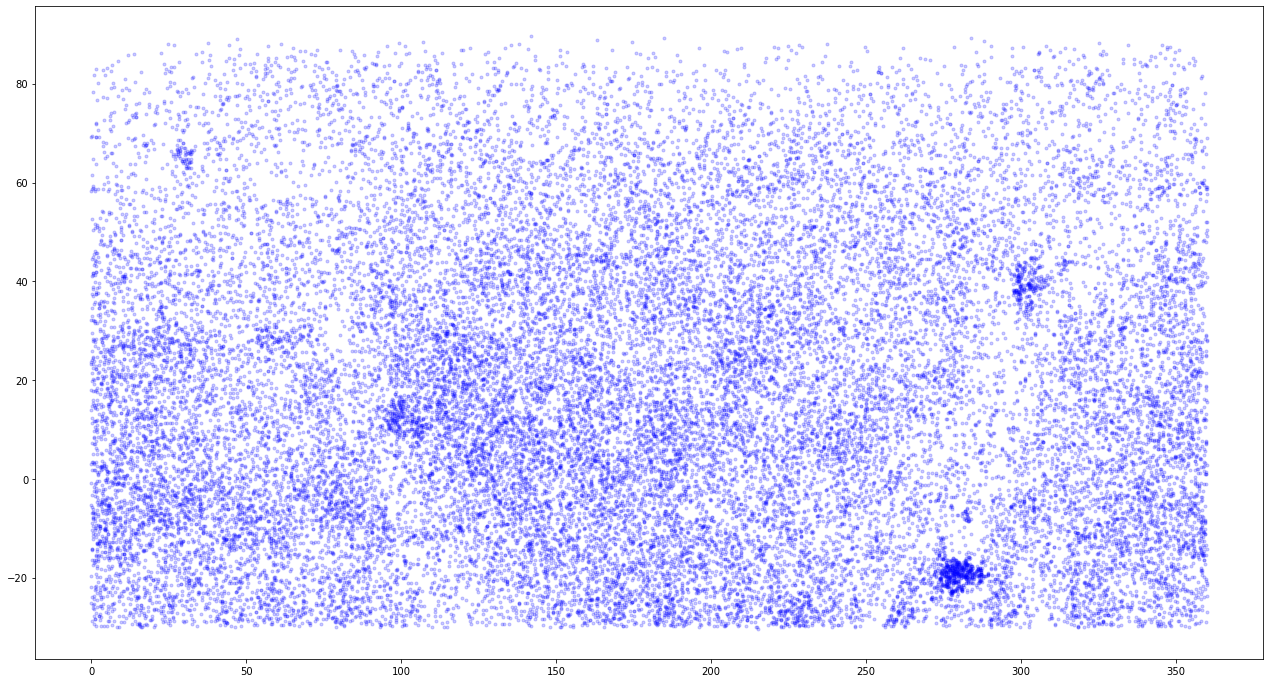

In [5]:
ev=10000
plt.figure(figsize=(22,12))
plt.plot(ras[::ev],decs[::ev],'b.',alpha=.2)

(311911.43777120346, 330133.8282287965)

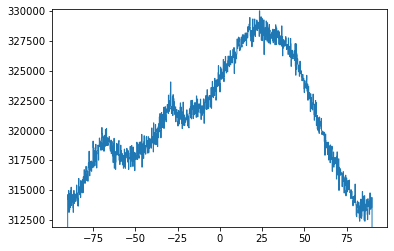

In [6]:
n,b,f=plt.hist(.5*np.arctan2(e2s,e1s)*180./np.pi,bins=1000,range=[-90,90],histtype='step')
plt.ylim(np.mean(n)-2.*np.std(n),np.mean(n)+2.*np.std(n))

In [7]:
e1s[::100000],e2s[::100000]

(array([-0.039575  , -0.03547999, -0.05401799, ..., -0.028475  ,
         0.038746  , -0.16325301]),
 array([ 0.01559054,  0.0371504 ,  0.01153228, ..., -0.078481  ,
        -0.0589938 , -0.1120112 ]))

(Text(0.5, 0, 'e1, e2'), None)

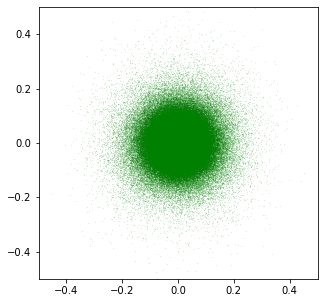

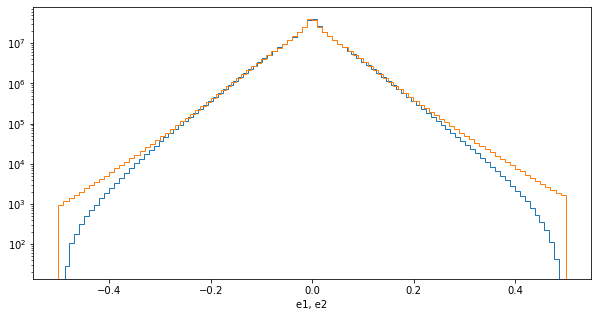

In [8]:
plt.figure(figsize=(5,5))
ev=1000
plt.plot(e1s[::ev],e2s[::ev],'g.',markersize=.1),plt.axis([-.5,.5,-.5,.5])
plt.figure(figsize=(10,5))
plt.hist(e1s,bins=100,histtype='step')
plt.hist(e2s,bins=100,histtype='step')
plt.xlabel('e1, e2'),plt.yscale('log')

In [9]:
###UGH SHOULD NOT HAVE CUT AT .25....aaaanyways

In [15]:
ra_min,ra_max,dec_min,dec_max=0,360,-30,90
r_max=7.0
nxpix,nypix=150,50

tstart = time.time()

e_image = np.zeros((nypix,nxpix),dtype=np.float32)
x,y=ras.astype(np.float32),decs.astype(np.float32)
e1,e2=e1s.astype(np.float32),e2s.astype(np.float32)

d_image = cuda.to_device(e_image)

print(time.time()-tstart)

# Configure the blocks
threadsperblock = (16,16)
blockspergrid_x = int(math.ceil(e_image.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(e_image.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


# Start the kernel 
create_massmap_gpu[blockspergrid, threadsperblock](x,y,e1,e2,ra_min,ra_max,dec_min,dec_max,r_max,d_image)
print(time.time()-tstart)
cuda.synchronize()
print(time.time()-tstart)

e_image=d_image.copy_to_host()

print(time.time()-tstart)


1.0615296363830566
3251.1610455513
3251.1614050865173
3251.1616518497467


In [16]:
fooname='ps1dr2-XYCUTPT25-radec_'+str((ra_min,ra_max,dec_min,dec_max))+'-rmax_'+str(r_max).replace('.','pt')+'-npix_'+str((nxpix,nypix))
fits.writeto(rootdir+fooname+'.cat',np.array([ras,decs,e1s,e2s]),overwrite=True)

outfitsname=fooname+'.fits'
writeout_wcs_massmap(rootdir+outfitsname,-e_image,ra_min,ra_max,dec_min,dec_max)
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

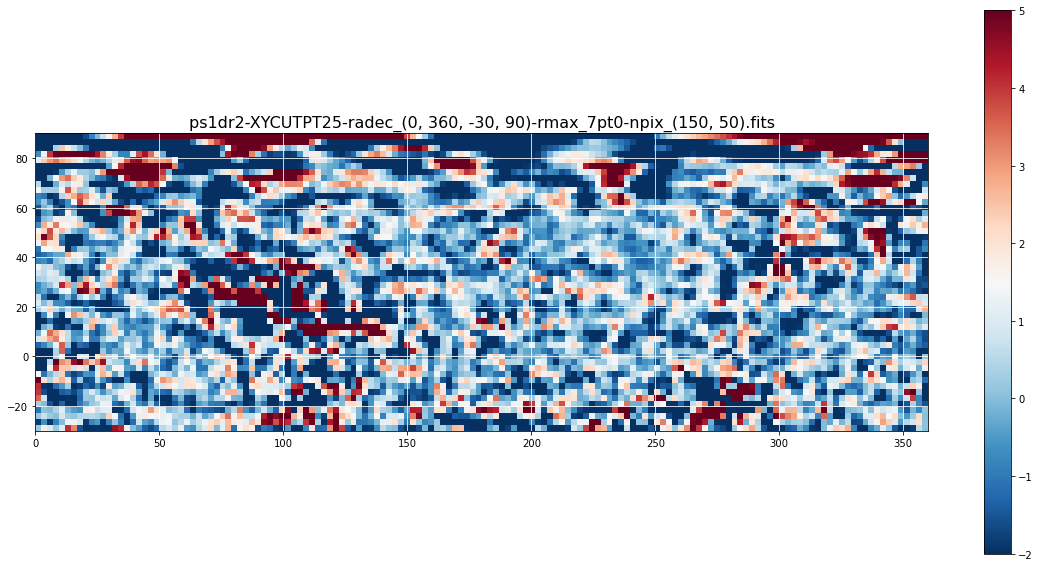

In [18]:
plt.figure(figsize=(20,10)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-2,vmax=5,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
plt.colorbar()#orientation='horizontal')

#gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
#plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'go',alpha=.7,markersize=18,
#         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=2)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
#plt.colorbar(orientation='horizontal')

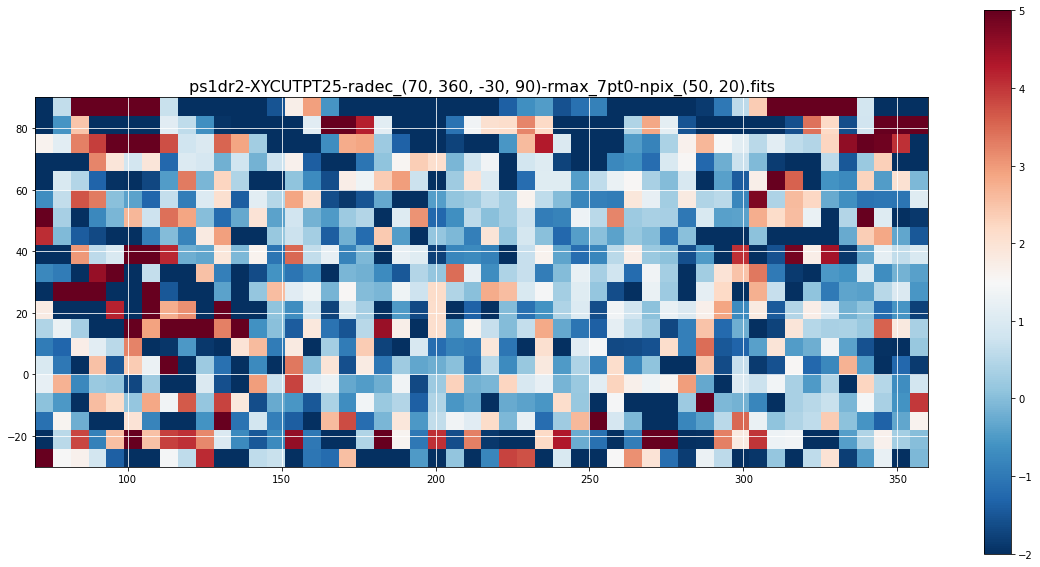

122750226

In [35]:
ra_min,ra_max,dec_min,dec_max=120,240,-30,90
gradec=np.where((ras>ra_min) & (ras<ra_max) & (decs>dec_min) & (decs<dec_max))
len(gradec[0])

x,y=ras[gradec].astype(np.float32),decs[gradec].astype(np.float32)
e1,e2=e1s[gradec].astype(np.float32),e2s[gradec].astype(np.float32)


r_max=10.0
nxpix,nypix=300,300

tstart = time.time()

e_image = np.zeros((nypix,nxpix),dtype=np.float32)

d_image = cuda.to_device(e_image)

print(time.time()-tstart)

# Configure the blocks
threadsperblock = (16,16)
blockspergrid_x = int(math.ceil(e_image.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(e_image.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


# Start the kernel 
create_massmap_gpu[blockspergrid, threadsperblock](x,y,e1,e2,ra_min,ra_max,dec_min,dec_max,r_max,d_image)
print(time.time()-tstart)
cuda.synchronize()
print(time.time()-tstart)

e_image=d_image.copy_to_host()

print(time.time()-tstart)


0.03011178970336914
5610.287399530411
5610.287636756897
5610.288133382797


In [36]:
fooname='ps1dr2-XYCUTPT25-radec_'+str((ra_min,ra_max,dec_min,dec_max))+'-rmax_'+str(r_max).replace('.','pt')+'-npix_'+str((nxpix,nypix))
fits.writeto(rootdir+fooname+'.cat',np.array([ras,decs,e1s,e2s]),overwrite=True)

outfitsname=fooname+'.fits'
writeout_wcs_massmap(rootdir+outfitsname,-e_image,ra_min,ra_max,dec_min,dec_max)
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

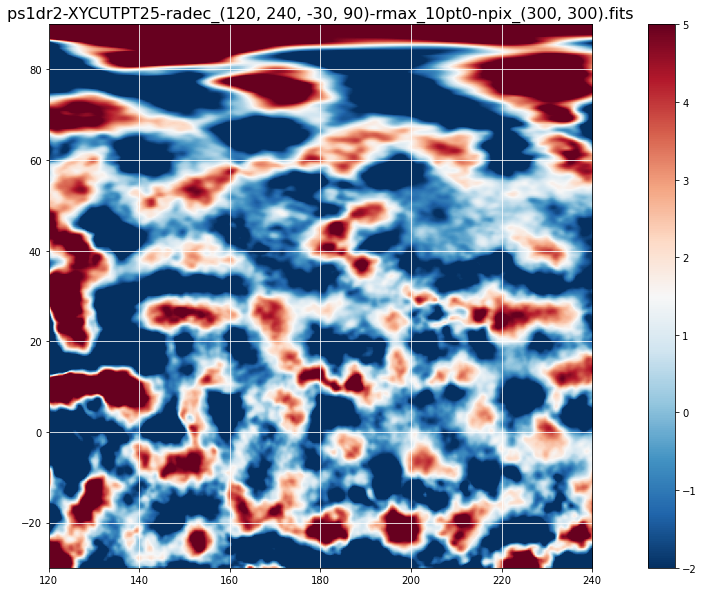

In [37]:
plt.figure(figsize=(20,10)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-2,vmax=5,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
plt.colorbar()#orientation='horizontal')

#gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
#plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'go',alpha=.7,markersize=18,
#         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=2)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
#plt.colorbar(orientation='horizontal')

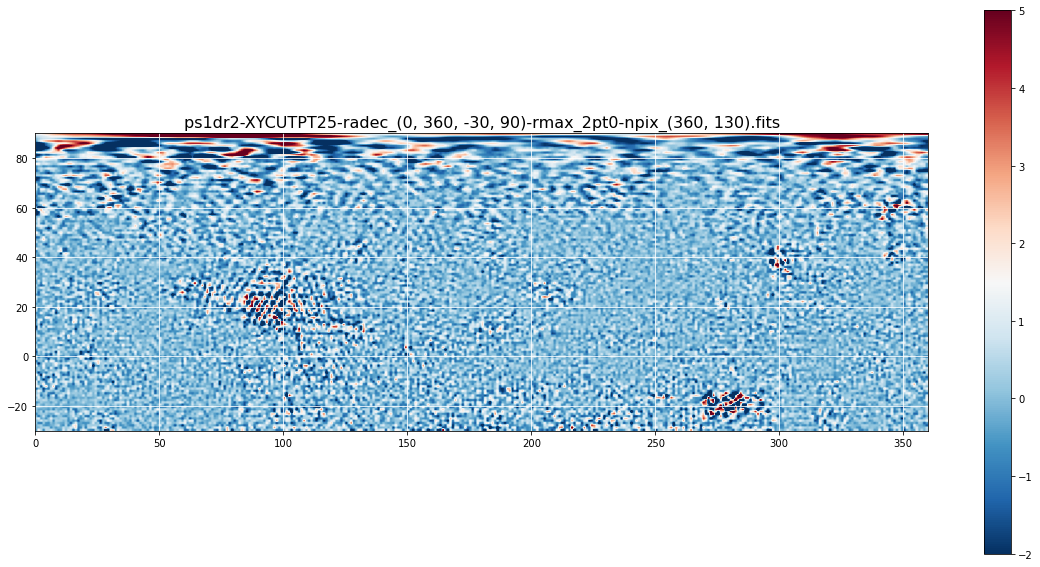

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1

(array([4.552e+03, 2.750e+02, 1.520e+02, 1.140e+02, 7.200e+01, 4.000e+01,
        2.900e+01, 8.000e+00, 4.000e+00, 3.000e+00]),
 array([0.    , 0.0373, 0.0746, 0.1119, 0.1492, 0.1865, 0.2238, 0.2611,
        0.2984, 0.3357, 0.373 ]),
 <a list of 10 Patch objects>)

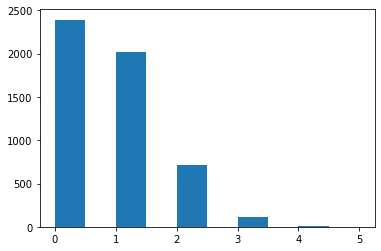

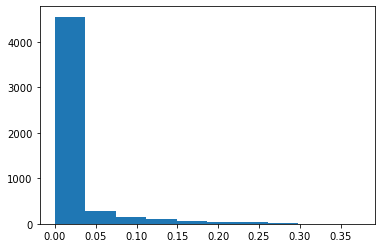

In [14]:
def get_abell_inds(ra_olapmin,ra_olapmax,dec_olapmin,dec_olapmax):
    gabell=np.where((catabell['rich']>2) & (catabell['z']<.5) & (catabell['ra']<ra_olapmax) & (catabell['ra']>ra_olapmin) &
                  (catabell['dec']<dec_olapmax) & (catabell['dec']>dec_olapmin))[0]
    return gabell

#Abell catalog from https://heasarc.gsfc.nasa.gov/W3Browse/galaxy-catalog/abell.html
file = open('/home/andrew/work/abell/catalog.txt','r')
lines=file.readlines()[6:]
file.close()

nabell=len(lines)

catabell={'ra':np.zeros(nabell),'dec':np.zeros(nabell),'name':[''  for foo in range(nabell)],'rich':np.zeros(nabell),
          'z':np.zeros(nabell)}

for i in range(nabell):
    line=lines[i]
    rah,dech=line.split('|')[2].replace(' ',':'),line.split('|')[3].replace(' ',':')
    cfoo=SkyCoord(ra=rah,dec=dech,unit=(u.hourangle, u.deg))
    catabell['ra'][i],catabell['dec'][i]=cfoo.ra.deg,cfoo.dec.deg
    catabell['rich'][i]=np.int(line.split('|')[-4])
    catabell['name'][i]=line.split('|')[1]
    catabell['z'][i]=np.float(line.split('|')[6])

catabell['name']=np.array(catabell['name'])

plt.figure()
plt.hist(catabell['rich'])
plt.figure()
plt.hist(catabell['z'])

/home/andrew/soft/anaconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2407: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


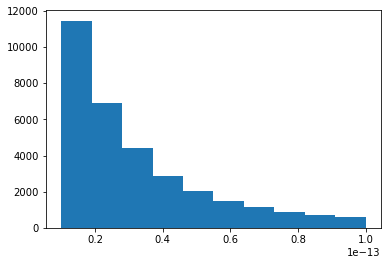

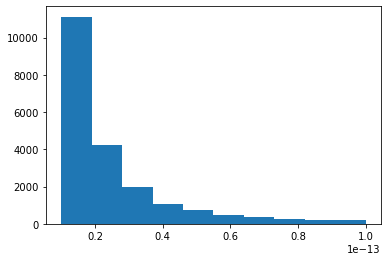

In [12]:
xcat=np.recfromcsv('/home/andrew/work/allsky/xmm-80degrees_around_radec_180_0.tsv',delimiter='\t')
xcat2=np.recfromcsv('/home/andrew/work/allsky/xmm-80degrees_around_radec_280_0.tsv',delimiter='\t')
plt.hist(xcat['flux'],range=[1e-14,1e-13])
plt.figure()
plt.hist(xcat['e_flux'],range=[1e-14,1e-13])
xcat=xcat[np.where((xcat['flux']>5e-14) & (xcat['e_flux']>5e-14))]
xcat2=xcat2[np.where((xcat2['flux']>5e-14) & (xcat2['e_flux']>5e-14))]

(0.0, 360.0, -30.0, 90.0)

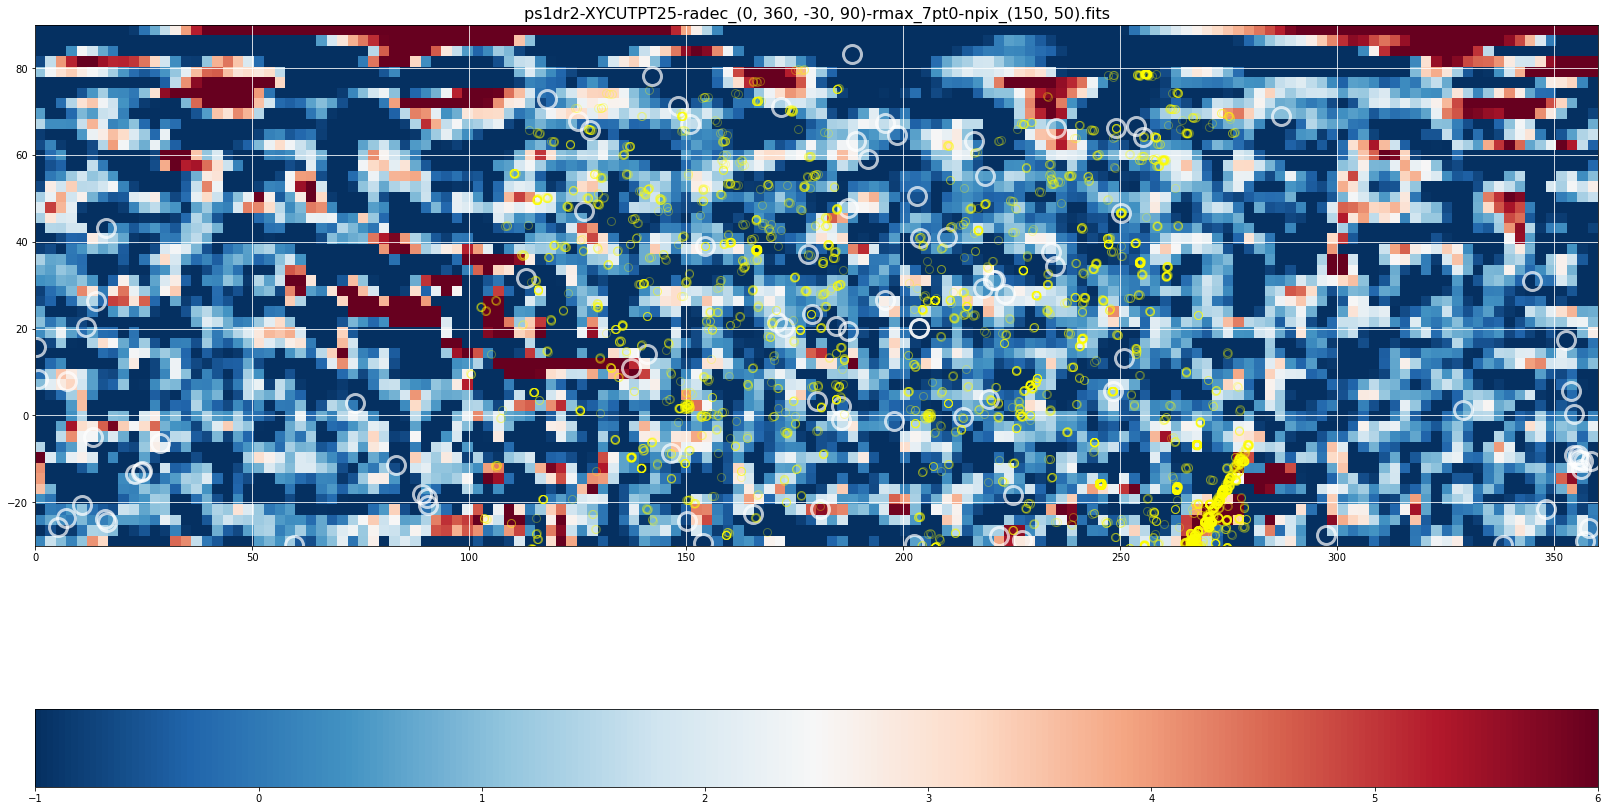

In [26]:
outfitsname='ps1dr2-XYCUTPT25-radec_(0, 360, -30, 90)-rmax_7pt0-npix_(150, 50).fits'
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

plt.figure(figsize=(28,20)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-1,vmax=6,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
#plt.colorbar(orientation='horizontal')

gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'co',alpha=.7,markersize=18,
         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=3)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
plt.colorbar(orientation='horizontal')

plt.plot(xcat['_raj2000'],xcat['_dej2000'],'go',alpha=.3,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.plot(xcat2['_raj2000'],xcat2['_dej2000'],'go',alpha=.3,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.axis([ra_min,ra_max,dec_min,dec_max])

(0.0, 360.0, -30.0, 90.0)

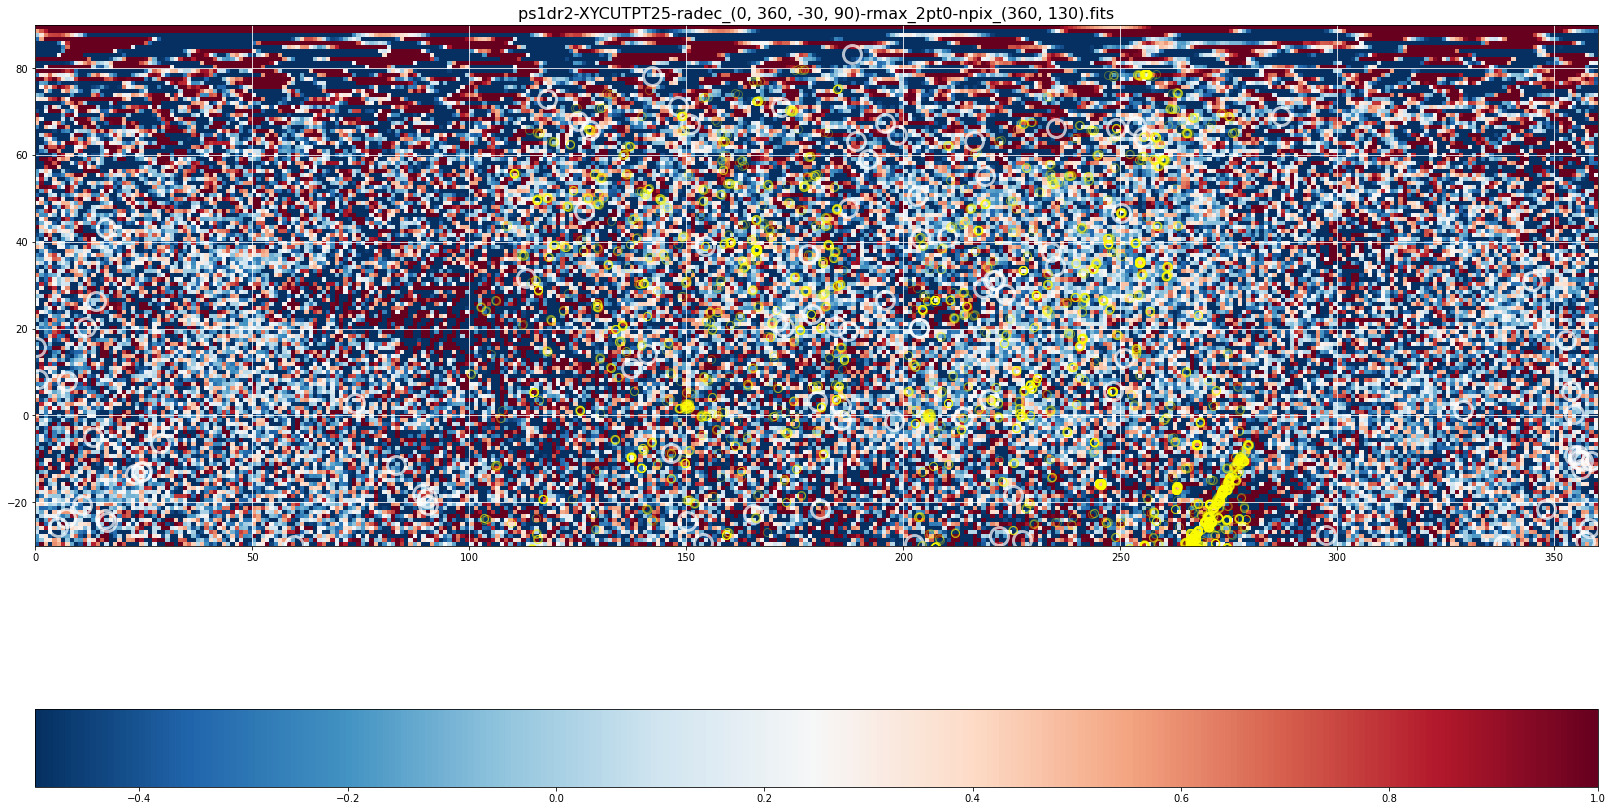

In [30]:
outfitsname='ps1dr2-XYCUTPT25-radec_(0, 360, -30, 90)-rmax_2pt0-npix_(360, 130).fits'
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

plt.figure(figsize=(28,20)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-.5,vmax=1,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
#plt.colorbar(orientation='horizontal')

gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'co',alpha=.7,markersize=18,
         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=3)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
plt.colorbar(orientation='horizontal')

plt.plot(xcat['_raj2000'],xcat['_dej2000'],'go',alpha=.3,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.plot(xcat2['_raj2000'],xcat2['_dej2000'],'go',alpha=.3,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.axis([ra_min,ra_max,dec_min,dec_max])

(120.0, 240.0, -30.0, 90.0)

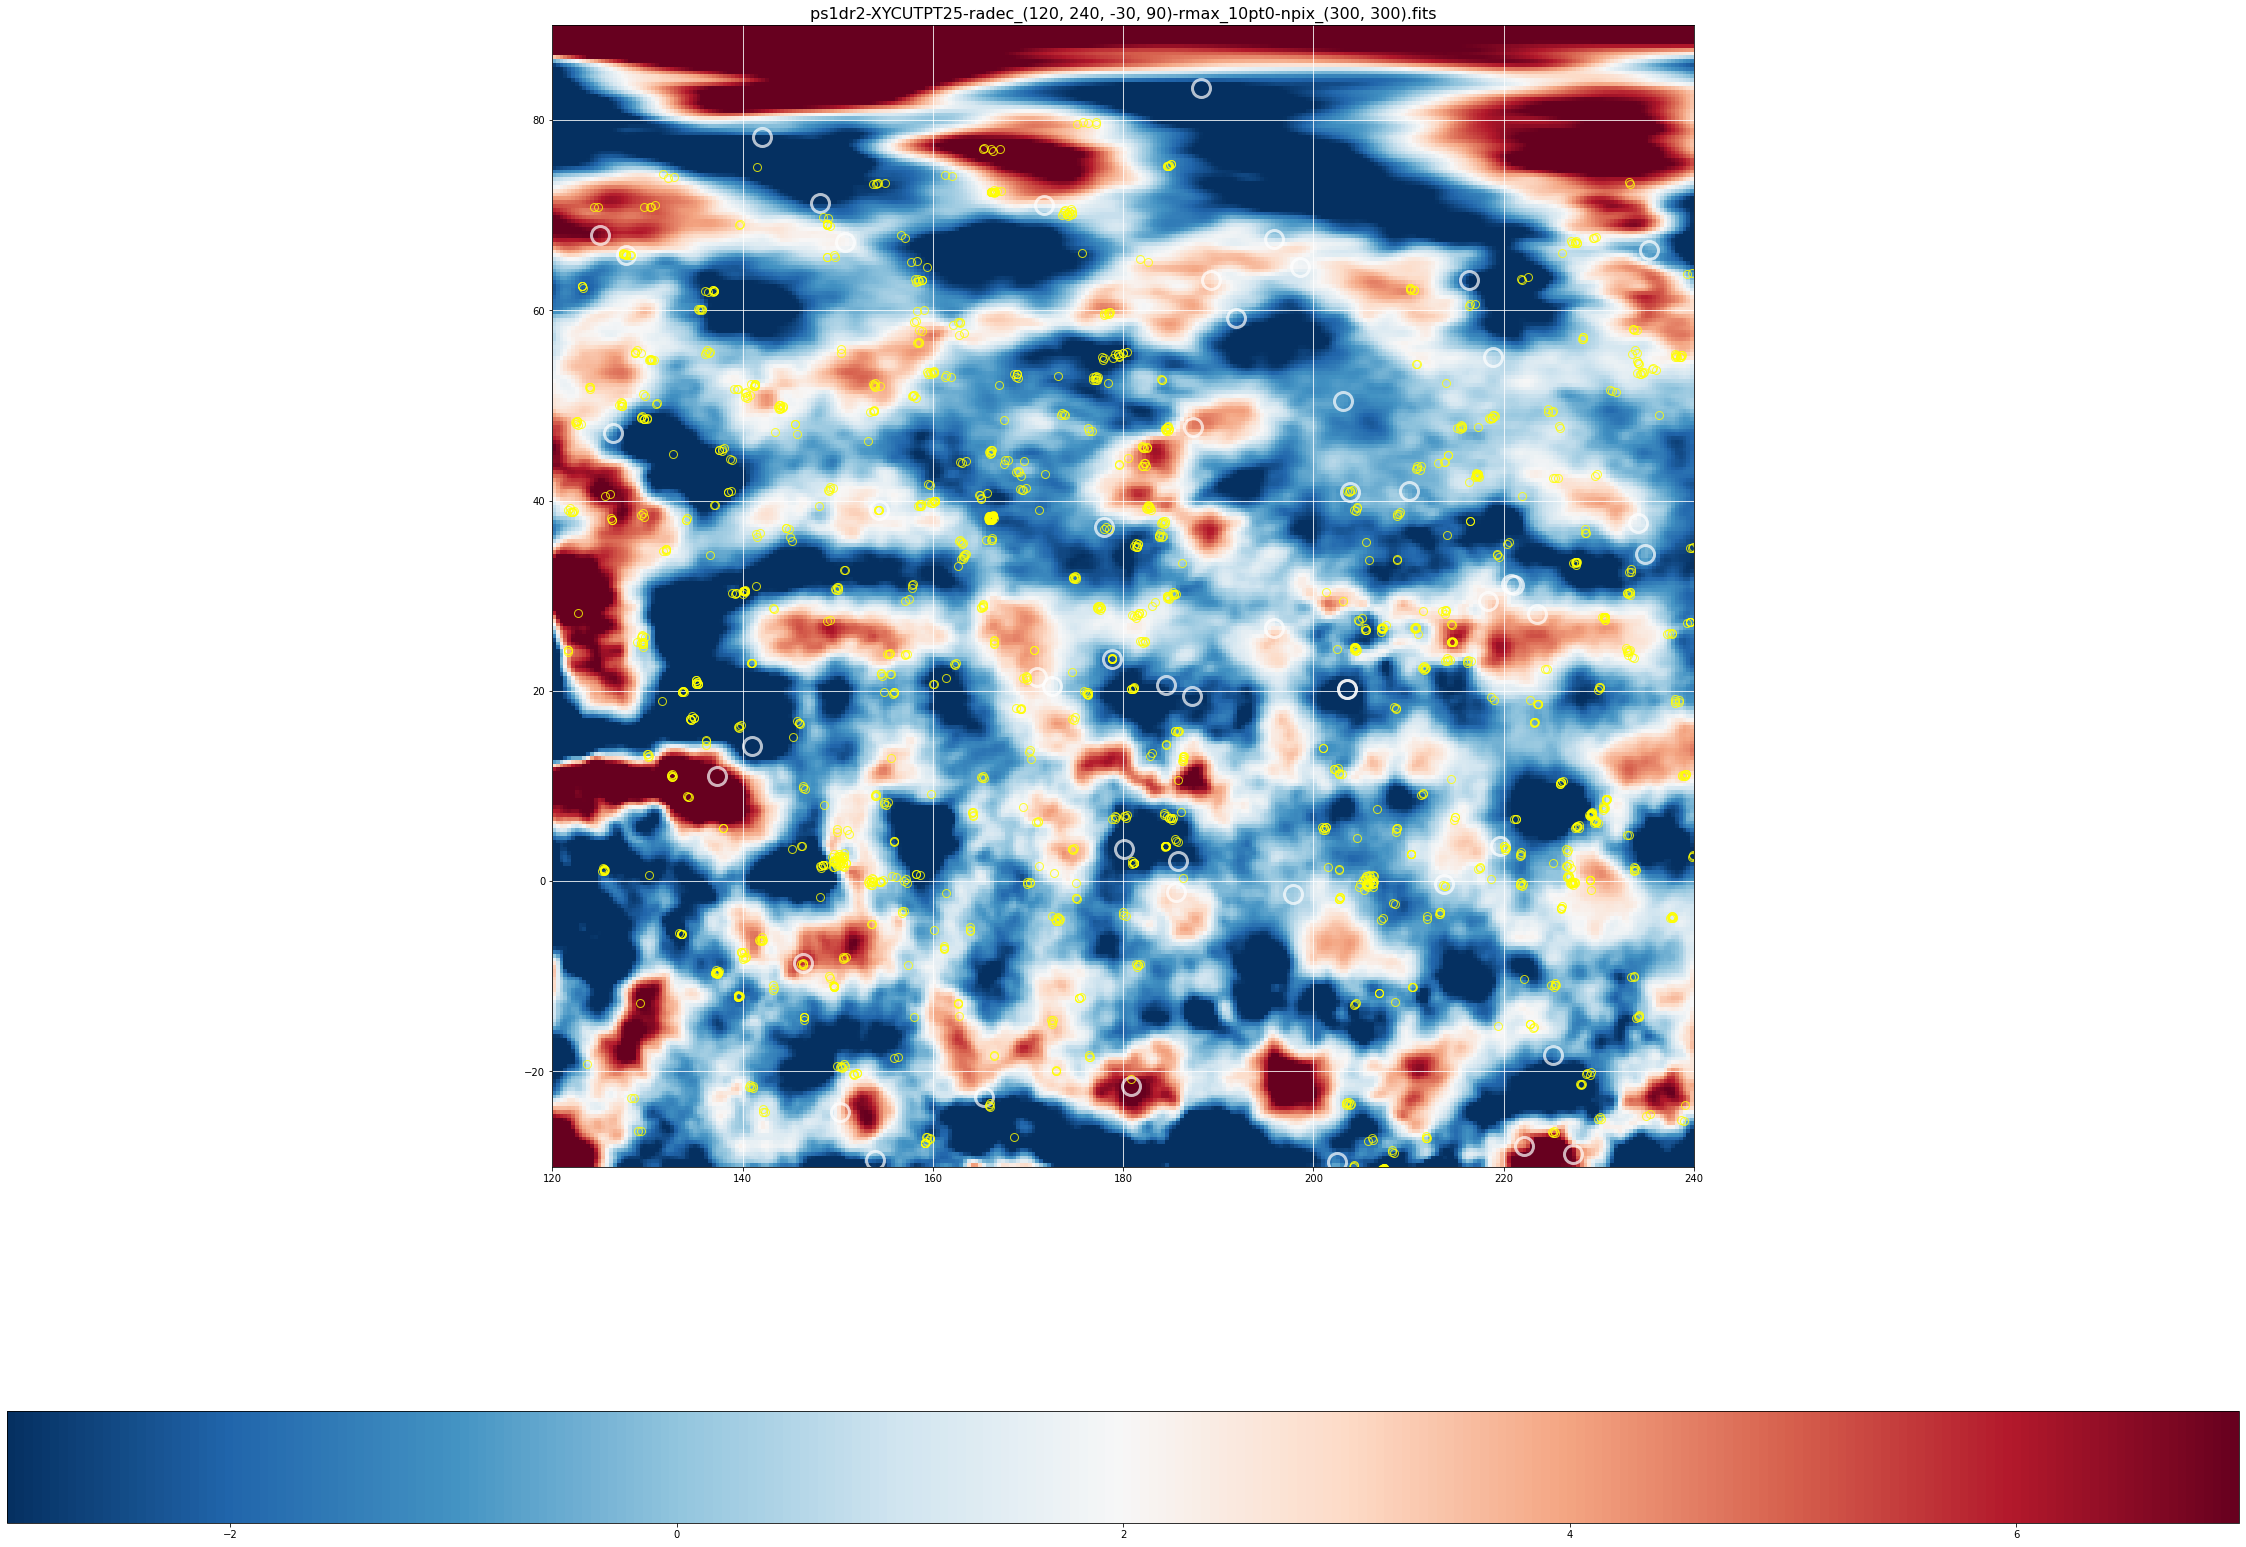

In [43]:
#outfitsname='ps1dr2-XYCUTPT25-radec_(0, 360, -30, 90)-rmax_2pt0-npix_(360, 130).fits'
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

plt.figure(figsize=(40,30)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-3,vmax=7,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
#plt.colorbar(orientation='horizontal')

gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'co',alpha=.7,markersize=18,
         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=3)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
plt.colorbar(orientation='horizontal')

plt.plot(xcat['_raj2000'],xcat['_dej2000'],'go',alpha=.8,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.plot(xcat2['_raj2000'],xcat2['_dej2000'],'go',alpha=.8,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.axis([ra_min,ra_max,dec_min,dec_max])

In [47]:
ra_min,ra_max,dec_min,dec_max=240,360,-30,90
gradec=np.where((ras>ra_min) & (ras<ra_max) & (decs>dec_min) & (decs<dec_max))
len(gradec[0])

x,y=ras[gradec].astype(np.float32),decs[gradec].astype(np.float32)
e1,e2=e1s[gradec].astype(np.float32),e2s[gradec].astype(np.float32)


r_max=10.0
nxpix,nypix=300,300

tstart = time.time()

e_image = np.zeros((nypix,nxpix),dtype=np.float32)

d_image = cuda.to_device(e_image)

print(time.time()-tstart)

# Configure the blocks
threadsperblock = (16,16)
blockspergrid_x = int(math.ceil(e_image.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(e_image.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


# Start the kernel 
create_massmap_gpu[blockspergrid, threadsperblock](x,y,e1,e2,ra_min,ra_max,dec_min,dec_max,r_max,d_image)
print(time.time()-tstart)
cuda.synchronize()
print(time.time()-tstart)

e_image=d_image.copy_to_host()

print(time.time()-tstart)


0.017961740493774414
4269.608330488205
4269.608523845673
4269.608948469162


In [ ]:
4603 seconds for 0 to 120

In [48]:
fooname='ps1dr2-XYCUTPT25-radec_'+str((ra_min,ra_max,dec_min,dec_max))+'-rmax_'+str(r_max).replace('.','pt')+'-npix_'+str((nxpix,nypix))
fits.writeto(rootdir+fooname+'.cat',np.array([ras,decs,e1s,e2s]),overwrite=True)

outfitsname=fooname+'.fits'
writeout_wcs_massmap(rootdir+outfitsname,-e_image,ra_min,ra_max,dec_min,dec_max)
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

(240.0, 360.0, -30.0, 90.0)

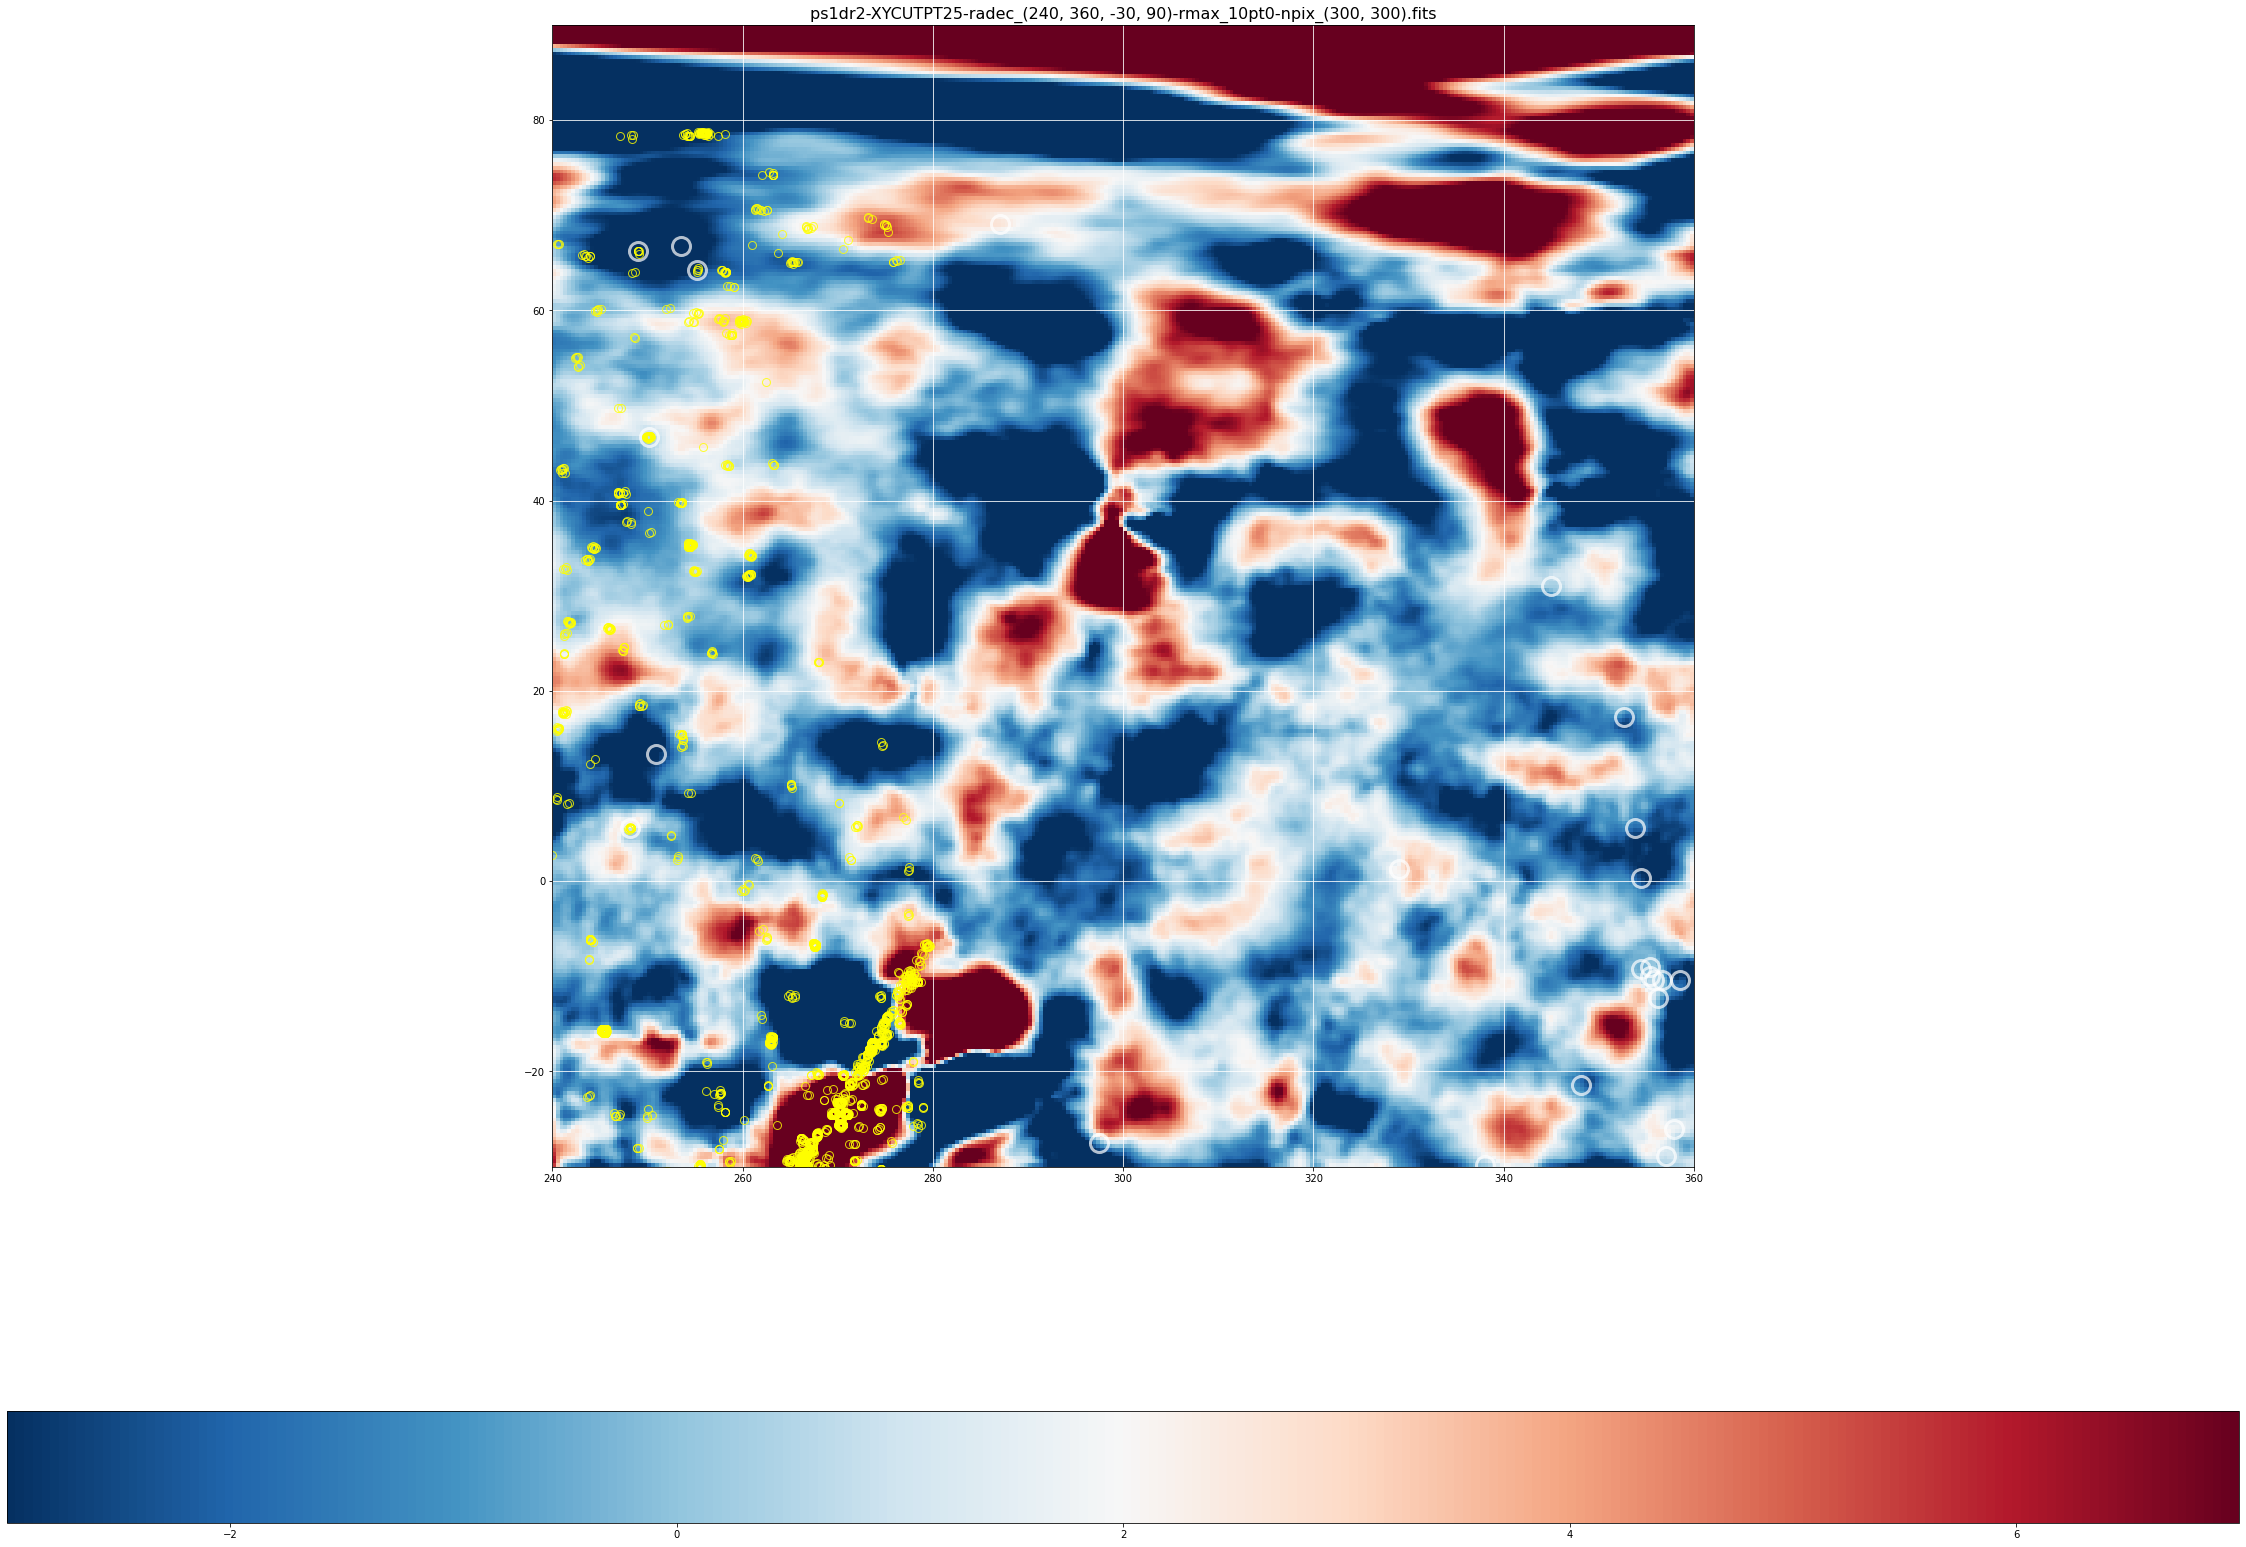

In [49]:
#outfitsname='ps1dr2-XYCUTPT25-radec_(0, 360, -30, 90)-rmax_2pt0-npix_(360, 130).fits'
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

plt.figure(figsize=(40,30)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-3,vmax=7,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
#plt.colorbar(orientation='horizontal')

gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'co',alpha=.7,markersize=18,
         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=3)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
plt.colorbar(orientation='horizontal')

plt.plot(xcat['_raj2000'],xcat['_dej2000'],'go',alpha=.8,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.plot(xcat2['_raj2000'],xcat2['_dej2000'],'go',alpha=.8,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.axis([ra_min,ra_max,dec_min,dec_max])

(0.0, 120.0, -30.0, 90.0)

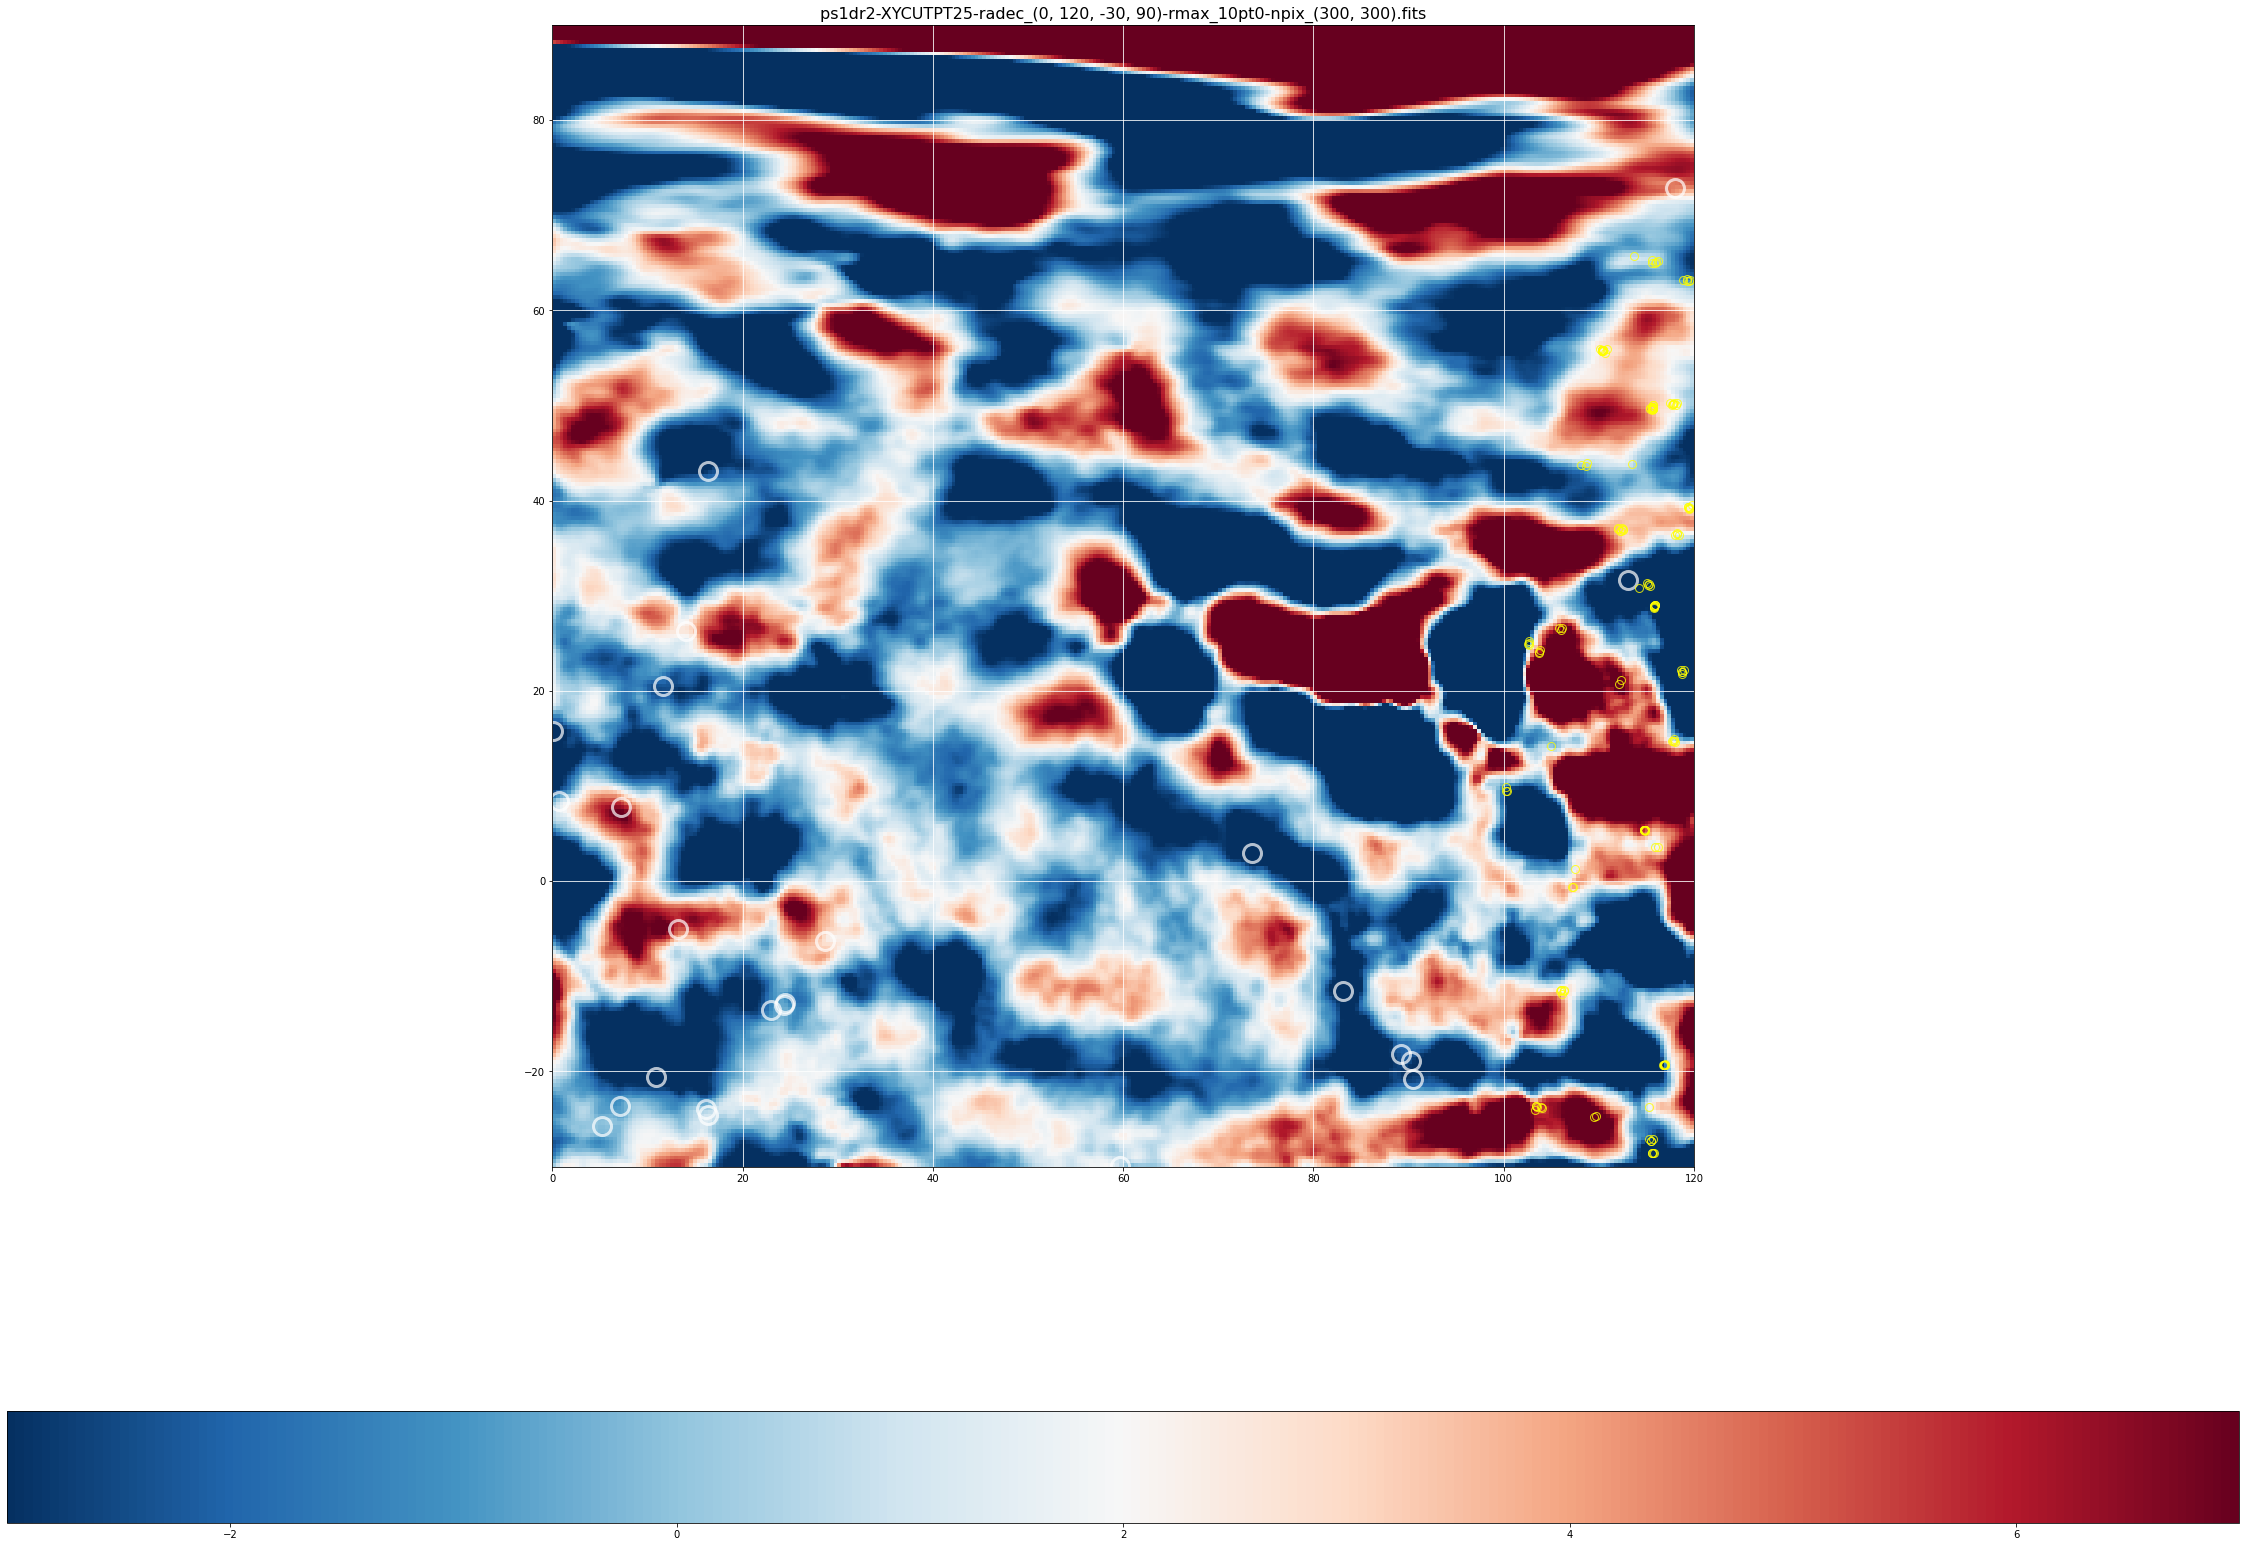

In [50]:
13*15

195

In [51]:
ra_min,ra_max,dec_min,dec_max=180,210,15,45
gradec=np.where((ras>ra_min) & (ras<ra_max) & (decs>dec_min) & (decs<dec_max))
len(gradec[0])

x,y=ras[gradec].astype(np.float32),decs[gradec].astype(np.float32)
e1,e2=e1s[gradec].astype(np.float32),e2s[gradec].astype(np.float32)


r_max=4.0
nxpix,nypix=300,300

tstart = time.time()

e_image = np.zeros((nypix,nxpix),dtype=np.float32)

d_image = cuda.to_device(e_image)

print(time.time()-tstart)

# Configure the blocks
threadsperblock = (16,16)
blockspergrid_x = int(math.ceil(e_image.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(e_image.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)


# Start the kernel 
create_massmap_gpu[blockspergrid, threadsperblock](x,y,e1,e2,ra_min,ra_max,dec_min,dec_max,r_max,d_image)
print(time.time()-tstart)
cuda.synchronize()
print(time.time()-tstart)

e_image=d_image.copy_to_host()

print(time.time()-tstart)


0.01832413673400879
429.0383243560791
429.0384602546692
429.0388696193695


In [53]:
fooname='ps1dr2-XYCUTPT25-radec_'+str((ra_min,ra_max,dec_min,dec_max))+'-rmax_'+str(r_max).replace('.','pt')+'-npix_'+str((nxpix,nypix))
#fits.writeto(rootdir+fooname+'.cat',np.array([ras,decs,e1s,e2s]),overwrite=True)

outfitsname=fooname+'.fits'
writeout_wcs_massmap(rootdir+outfitsname,-e_image,ra_min,ra_max,dec_min,dec_max)
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

(180.0, 210.0, 15.0, 45.0)

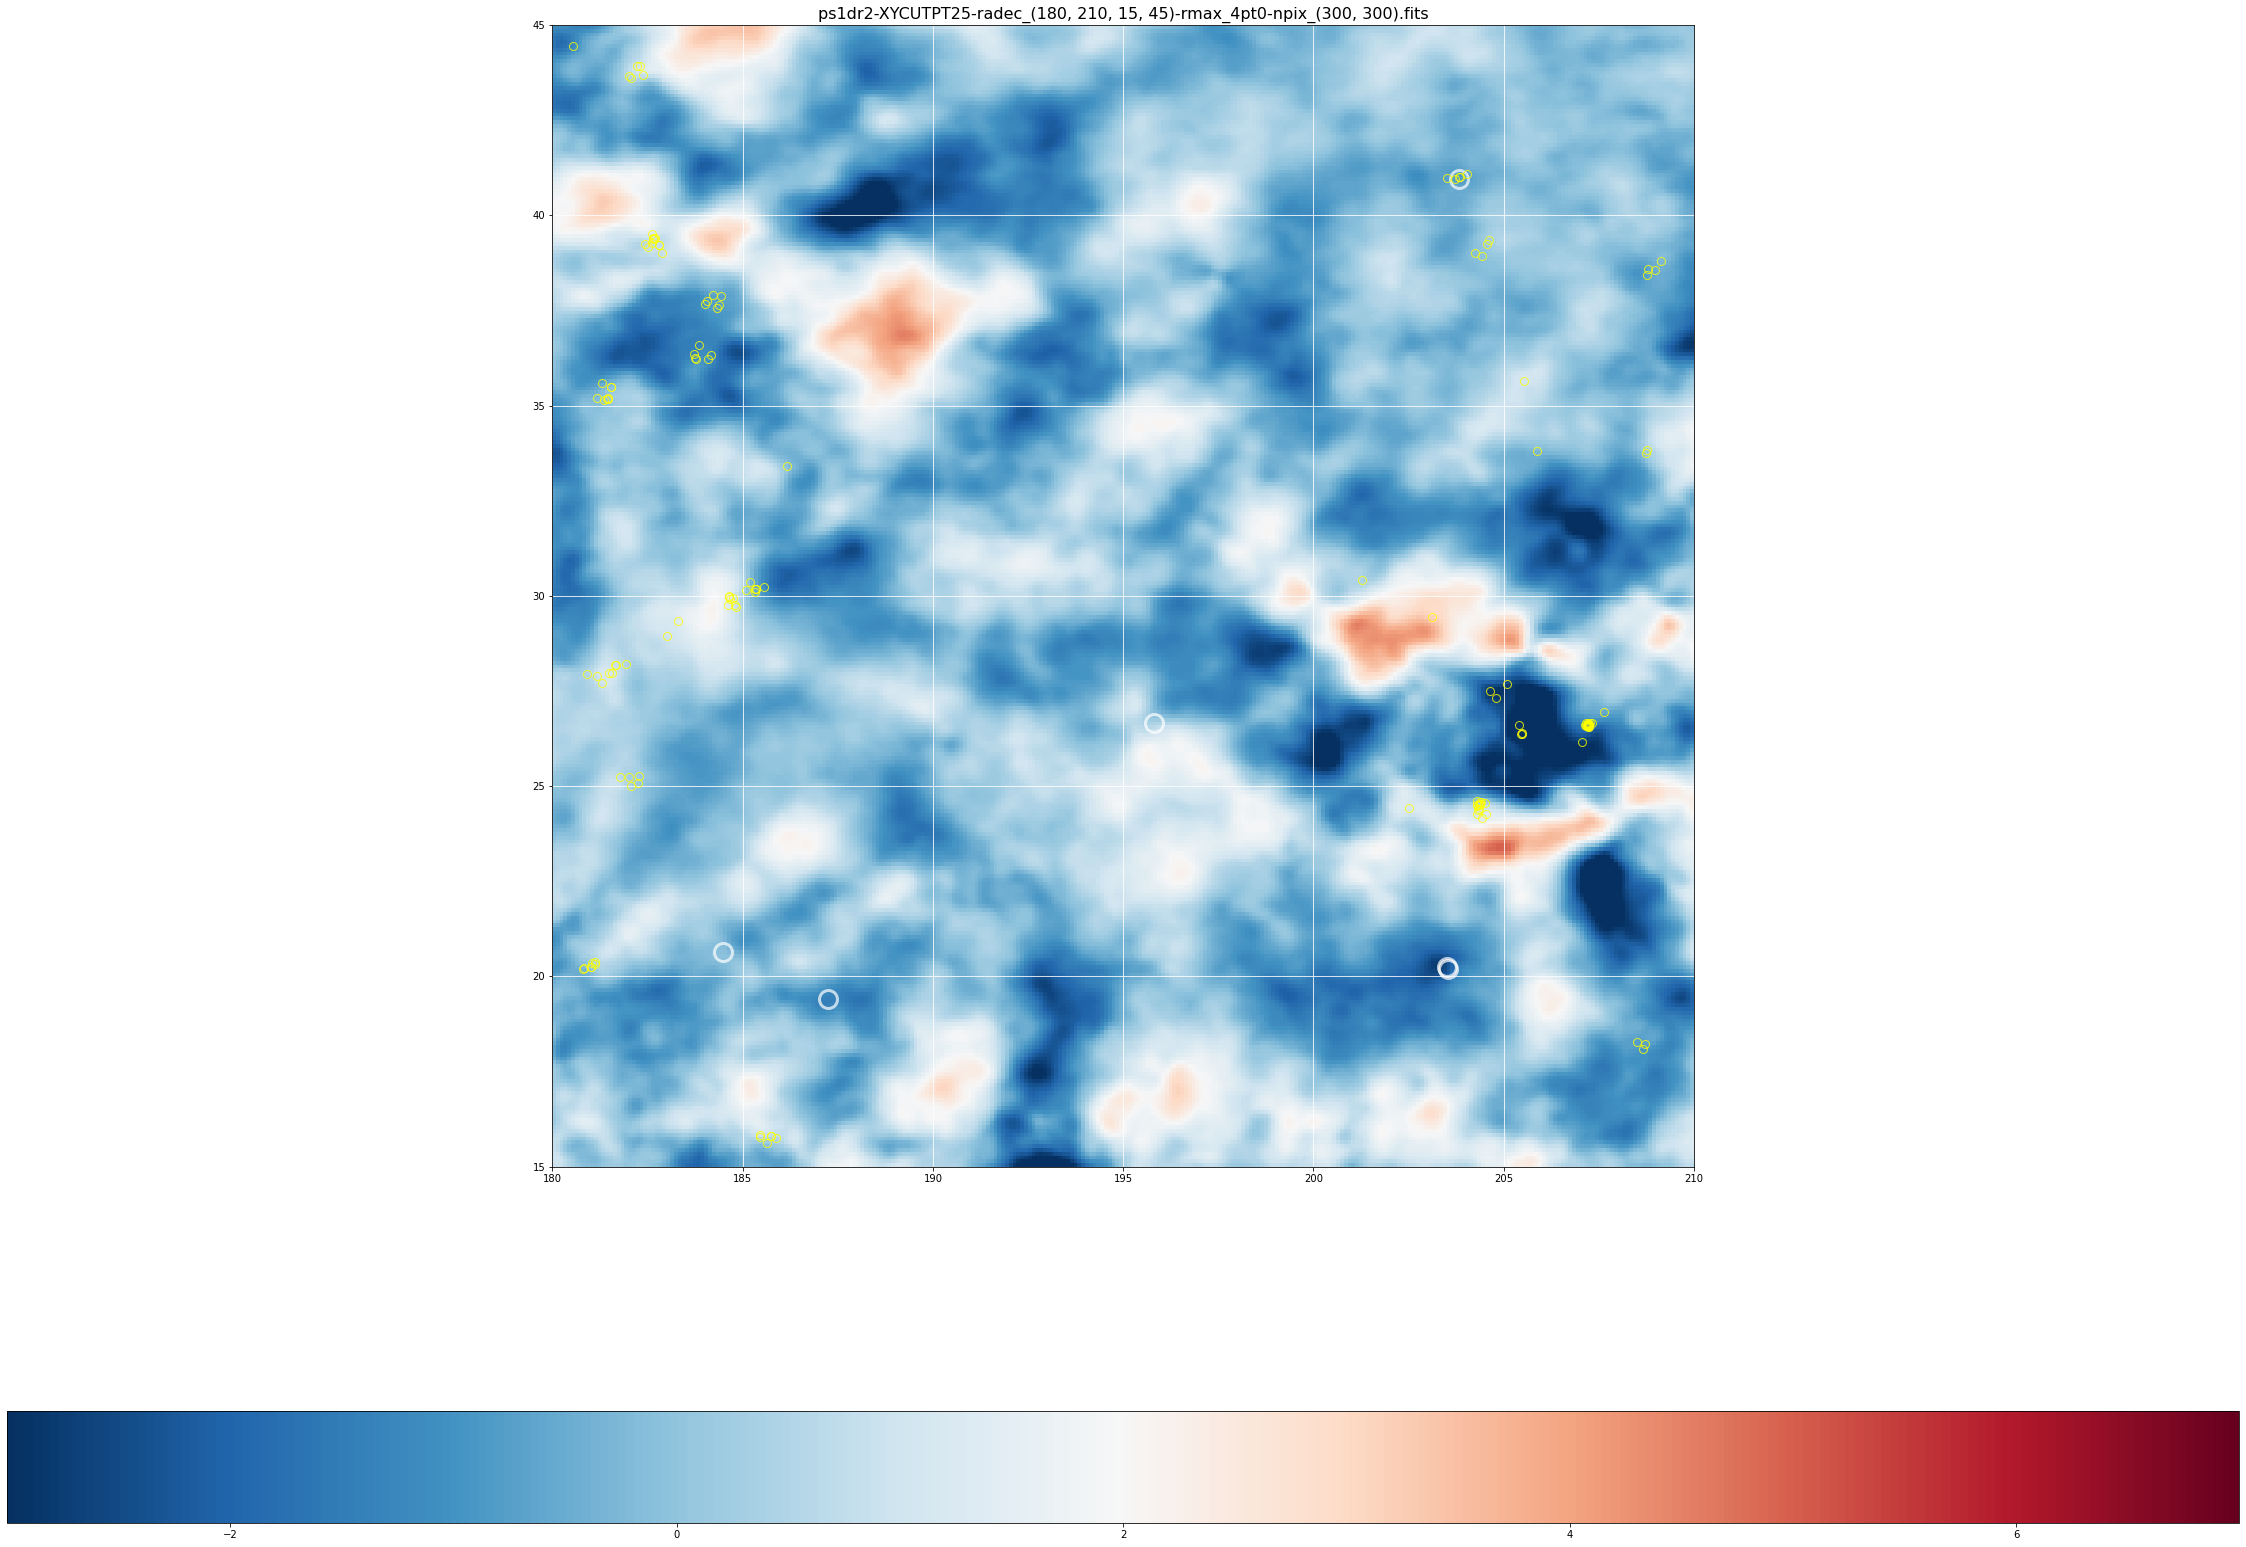

In [54]:
#outfitsname='ps1dr2-XYCUTPT25-radec_(0, 360, -30, 90)-rmax_2pt0-npix_(360, 130).fits'
ra,dec,e=readin_wcs_massmap(rootdir+outfitsname)

plt.figure(figsize=(40,30)),plt.title(outfitsname,fontsize=16)
plt.imshow(e,cmap=plt.cm.RdBu_r,vmin=-3,vmax=7,origin='lower',extent=[ra_min,ra_max,dec_min,dec_max])
#plt.colorbar(orientation='horizontal')

gabell=get_abell_inds(ra_min,ra_max,dec_min,dec_max)
plt.grid(color='w')
plt.plot(catabell['ra'][gabell],catabell['dec'][gabell],'co',alpha=.7,markersize=18,
         label='Abell catalog', markeredgecolor='w',mfc='None',markeredgewidth=3)
#for gg in gabell:
    #plt.text(catabell['ra'][gg],catabell['dec'][gg],str(catabell['name'][gg]),color='w',fontsize=20)
plt.colorbar(orientation='horizontal')

plt.plot(xcat['_raj2000'],xcat['_dej2000'],'go',alpha=.8,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.plot(xcat2['_raj2000'],xcat2['_dej2000'],'go',alpha=.8,markersize=8,
         label='Abell catalog', markeredgecolor='yellow',mfc='None',markeredgewidth=1)
plt.axis([ra_min,ra_max,dec_min,dec_max])